# Land Cover Classification with Convolutional Neural Network

This notebook trains a CNN to recognise land cover type by training on images from the EuroSAT dataset based on Sentinel-2 satellite imagery.

Each example is a 64 x 64 x 3 RGB digitized image 

For more information regarding this dataset see https://zenodo.org/record/7711810#.ZAm3k-zMKEA

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Explore Images

In [3]:
base_dir = "./EuroSAT_RGB"
for dir in os.listdir(base_dir):
    print(f"there are {len(os.listdir(os.path.join(base_dir,dir)))} images in {dir}")

there are 3000 images in AnnualCrop
there are 3000 images in Forest
there are 3000 images in HerbaceousVegetation
there are 2500 images in Highway
there are 2500 images in Industrial
there are 2000 images in Pasture
there are 2500 images in PermanentCrop
there are 3000 images in Residential
there are 2500 images in River
there are 3000 images in SeaLake


Printing random sample images
Each image has shape: (64, 64, 3)


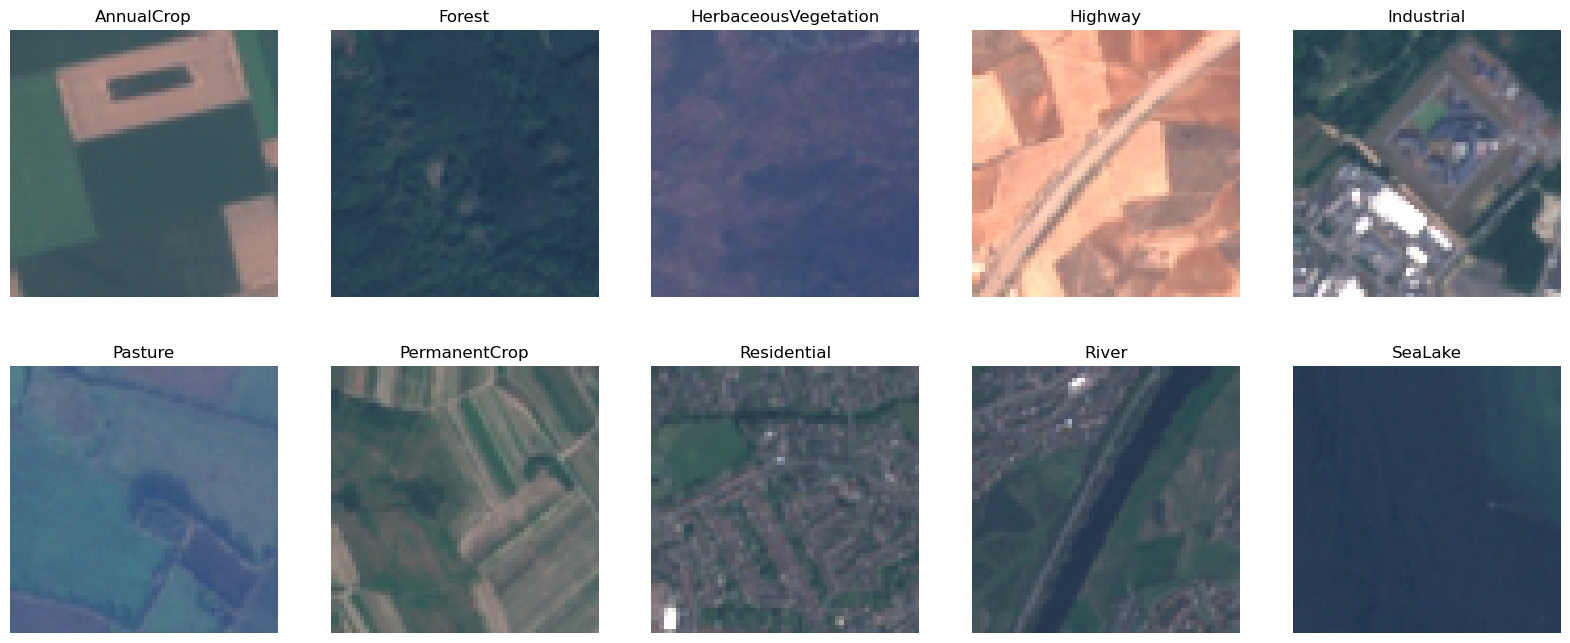

In [4]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img

print("Printing random sample images")

nrows = 2
ncols = 5
index = np.random.randint(0,2499)

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

for i, img_path in enumerate(os.listdir(base_dir)):
    img_dir = os.path.join(base_dir, img_path)
    sample_image = load_img(f"{os.path.join(img_dir, os.listdir(img_dir)[index])}")
    if i == 0:
        # Convert an image into its numpy array representation
        sample_array = img_to_array(sample_image)
        print(f"Each image has shape: {sample_array.shape}")
    
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.title.set_text(img_path)
    sp.axis('Off') # Don't show axes (or gridlines)
    
    plt.imshow(sample_image)

### Split images for validation
This function will create a new folder with a random 80% of images per class for training and another with 20% of the images per class for validating the model.

In [4]:
# import splitfolders
# splitfolders.ratio(base_dir, output="eurosat_train_test", seed=1337, ratio=(.8, 0.2,0)) 

In [14]:
train_dir = r"eurosat_train_test/train"
validation_dir = r"eurosat_train_test/val"

#### Data preprocessing
Training and validation image data generators.
Now that the data are split into training and validation sets, create generators to feed the labelled images to the network.

#### Normalization and Augmentation
We can also normalize (rescale) the images during this step as well as expand the training set through augmentation to prevent overfitting on the original training set.

In [15]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
    
    # instantiate the image generator class with normalization and augmentation
    train_datagen = ImageDataGenerator(rescale=1/255,
                                      rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest')
    
    # now use the flow from directory method
    train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                      batch_size=50,
                                                      class_mode='categorical',
                                                      target_size=(64, 64))
    
    # repeat for validation set, no augmentation necessary
    validation_datagen = ImageDataGenerator(rescale=1/255)
    
    validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                                 batch_size=25,
                                                                 class_mode='categorical',
                                                                 target_size=(64, 64),
                                                                 shuffle=False)
    
    return train_generator, validation_generator

In [16]:
train_generator, validation_generator = train_val_generators(train_dir, validation_dir)

Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


### Building and compiling the model
Now we will build the CNN architecture using the sequential API and compile it with the Adam optimizer and a very small learning rate.

- use 3x3 filters for convolving.

- use 2x2 for pooling

The model initially suffered from underfitting, with high bias resulting in poor training accuracy. To combat this I deepened the network with more convolutional and dense layers, increased the number of neurons in dense layers and trained the model for more epochs.

Dropout of 0.1 is used to prevent overfitting.

In [17]:
def create_model():
    
    model = tf.keras.models.Sequential([
        # first convolution
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(64, 64,3)),
        tf.keras.layers.MaxPooling2D(2,2),
        # second convolution
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        # third convolution
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        # flattening layer
        tf.keras.layers.Flatten(),
        # dropout to prevent overfitting
        tf.keras.layers.Dropout(0.1),
        # first dense layer with 256 neurons
        tf.keras.layers.Dense(256, activation='relu'),
        # second dense layer with 512 neurons
        tf.keras.layers.Dense(512, activation='relu'),
        # one output layer with 10 neurons (one for each class) and softmax activation for multiclass classification
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                 loss = 'categorical_crossentropy',
                 metrics=['accuracy'])
    
    return model

### Training and testing the model accuracy
First extend the callback class to create a callback that stops the model training further if 95% validation accuracy has been reached.

In [18]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get("val_accuracy") is not None and logs.get("val_accuracy") > 0.95:
            print("\n95% validation accuracy reached, stopping training.")
            self.model.stop_training = True

In [19]:
# instantiate the model and the callback
model = create_model()
callbacks = myCallback()

# train the model
history = model.fit(train_generator,
                   epochs=100,
                   validation_data=validation_generator,
                   callbacks=[callbacks])

Epoch 1/100
432/432 [==============================] - 53s 121ms/step - loss: 1.3391 - accuracy: 0.4798 - val_loss: 1.0556 - val_accuracy: 0.5994
Epoch 2/100
432/432 [==============================] - 96s 222ms/step - loss: 0.8629 - accuracy: 0.6881 - val_loss: 0.6999 - val_accuracy: 0.7433
Epoch 3/100
432/432 [==============================] - 95s 220ms/step - loss: 0.7681 - accuracy: 0.7229 - val_loss: 0.6789 - val_accuracy: 0.7472
Epoch 4/100
432/432 [==============================] - 94s 218ms/step - loss: 0.7023 - accuracy: 0.7448 - val_loss: 0.6727 - val_accuracy: 0.7657
Epoch 5/100
432/432 [==============================] - 94s 218ms/step - loss: 0.6632 - accuracy: 0.7594 - val_loss: 0.6316 - val_accuracy: 0.7689
Epoch 6/100
432/432 [==============================] - 96s 221ms/step - loss: 0.5978 - accuracy: 0.7838 - val_loss: 0.5575 - val_accuracy: 0.7989
Epoch 7/100
432/432 [==============================] - 96s 222ms/step - loss: 0.5598 - accuracy: 0.7991 - val_loss: 0.6086 -

### Plot model training history

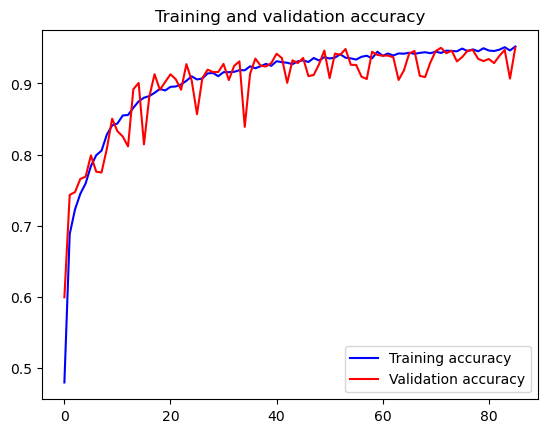

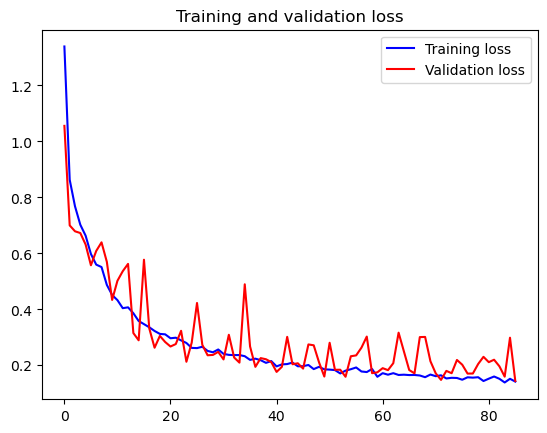

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs=range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Validation accuracy and loss that tracks training accuracy and loss closely is a good sign that we are not suffering from overfitting.

### Confusion Matrix
lets determine whether the model is good at predicting land use and which classes the model is better/worse at predicting

216/216 [==============================] - 2s 11ms/step
Confusion Matrix


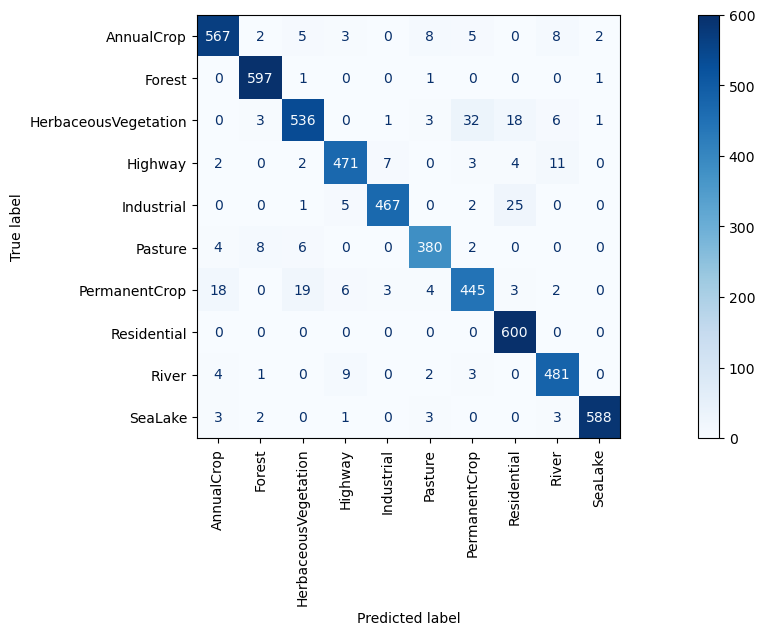

In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_test = validation_generator.classes

labels = [x for x in os.listdir(base_dir)]
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

print('Confusion Matrix')
plt.rcParams["figure.figsize"] = (20,5.5)
disp.plot(cmap=plt.cm.Blues,xticks_rotation=90)
plt.show()